<h1><center>Final Assignement</center></h1>

<a class="anchor" id="0"></a>
### Table of content
1. [Setup](#1)<br>
2. [Define the functions as input to pipeline](#2)<br>
    2.1 [Preparational tasks](#21)<br>
    2.2 [Model creation](#22)<br>
    2.3 [Model training](#23)<br>
    2.4 [Create Forecast](#24)<br>
    2.5 [Finishing tasks - write to csv and save](#25)<br>
3. [Define and run pipeline](#3)<br>

This is the second Notebook. It has the following tasks:
- used to retrieve the data prepared in the first notebook, 
- get the different combinations of departments / stores (70)
- loop through those combinations of departments / stores
    - filter the data down to each different combination of items
    - create embeddings
    - prepare filtered dataframes like with normalization
    - train, test, val split of the data
    - create batches of data
    - retrieve the optimal config hyperparams from the keras tuner runs
    - create DL model
    - train DL model
    - create the rolling forecast predictions
    - test / check the output of the model or write forecast to csv file and store it
    - depending on testing or evaluation mode return either the evaluation dataframe or the created forecast

The baseline model is defined in V4 of the models and because due to the size left out at this point. It achieved a WRMSSE of 1.43 on Kaggle which I constantly improved on over the last model versions until this Version 9. I therefore went from a very simple one layer model with only 16 or 32 units to multiple layers with more neurons (see report for in detail discussion). Therefore step 5 and 6 of the Chollet book is covered in the last model versions. 

Regularizing and hyperparameter tuning is conducted extensively in V8 of the models. 
Finally step as part of Chollet's step 7 I retrained the best models on all the training data under section 3 and evaluated it on test set using the Kaggle platform achieving a WRMSSE score of 1.26 on Kaggle. 

<br>
<a id='1'></a>
<h2>1. Setup (imports, get environment, number of GPUs, set path, directories of pickl dataframes)</h2>

In [1]:
#Import data handling libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import requests
import helper_functions as hf
import os
from types import SimpleNamespace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Embedding, Dropout, concatenate, Flatten, Bidirectional, GlobalAveragePooling1D)
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import Huber, MeanAbsoluteError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
# Setting to adjust before each run:
CODE_ENV = hf.detect_environment()
STATUS = 'training' #'production' 'training'

Environment: local


In [3]:
if CODE_ENV == 'kaggle':
    !pip install keras_self_attention
from keras_self_attention import SeqSelfAttention

In [4]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Is build with cuda: " + str(tf.test.is_built_with_cuda()))

Num GPUs Available:  0
Is build with cuda: False


In [5]:
#Specify directories
dirs = hf.get_paths(CODE_ENV)
parent_dir = dirs['parent_dir']
res_dir = dirs['res_dir']
src_dir = dirs['src_dir']
prc_dir = dirs['prc_dir']
sub_dir = dirs['sub_dir']
CONFIG_DIR = dirs['CONFIG_DIR']
CSV_PATH = dirs['CSV_PATH']

In [6]:
# Create variables
VALIDATION_DATA  = prc_dir +'df_1.pkl' # Validation data
BASE      = prc_dir +'df_2.pkl' # Base data
CALENDAR  = prc_dir +'df_3.pkl' # Calendar data
# NUM_ITEMS = 30490 # Number of items per each day

DAYS_PER_SEQUENCE = 28  # Length of the sequence
MAX_BATCH_SIZE = 900 # Maximum number of ids to be used in each batch to avoid memory issues and curse of dimensionality


TARGET_COL = 'sales_amount'

# List to hold all feature columns that are used for each item
REPEATED_FEATURES = ['sales_amount', 'sell_price', 'is_available',
                     'sales_amount_moving_avg_7', 'sales_amount_moving_avg_28', 'sales_amount_lag_1',
                     'zero_sales_available', 'consecutive_zero_sales']
SALES_AMOUNT_COLS = ['sales_amount', 'sales_amount_moving_avg_7', 'sales_amount_moving_avg_28', 'sales_amount_lag_1']

# List to hold feature columns that are not repeated for each item
ONCE_ONLY_FEATURES = ['snap_CA', 'snap_TX', 'snap_WI', 'mday_normalized', 'day_continuous_normalized',
                      'month_sin', 'month_cos', 'wday_sin', 'wday_cos', 'week_sin', 'week_cos', 
                      'year_normalized'] 
EVENT_COLS = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
EVENT_LEN = len(EVENT_COLS)
NOT_NEEDED_COLS = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [7]:
# Set test_end to 1969 in case of production
if STATUS=='production':
    TEST_END = 1969
elif STATUS=='training':
    TEST_END = 1969 #1941

# Splitting the data in train, validation and test set; days are now 0 based, so have to shift by 1
# Define duration in days of each set
VAL_DUR   = 28
TEST_DUR  = 28

# Define end days of training set for each set
VAL_END   = TEST_END - TEST_DUR
TRAIN_END = VAL_END - VAL_DUR # 1885 -> Train only until the 28 days before the end of the data

# Finally define duration in days for the train set
TRAIN_DUR = TRAIN_END - DAYS_PER_SEQUENCE# Depends on whether the whole dataset is used or last the 28 days for validation 

<br>
<a id='2'></a>
<h2>2. Define the functions</h2>

<a id='21'></a>
<h3>2.1 Preparational tasks</h3>

In [8]:
def get_whole_data():
    """
    Read in df_train_conv from pickle file
    """
    df_all_data = pd.concat([pd.read_pickle(BASE),
                  pd.read_pickle(CALENDAR)], 
                  axis=1)
    return df_all_data

In [9]:
def get_combinations(df_all_data):
    """
    Return a df with all unique combinations of store_id and dept_id
    """
    # get all store_id and dept_id combinations
    df_combinations_store_dep = df_all_data[['store_id','dept_id']].drop_duplicates().reset_index(drop=True)
    # get the length of the df_combinations_store_dep
    df_length = len(df_combinations_store_dep)

    return df_combinations_store_dep, df_length

In [10]:
def create_empty_submission_df():
    """
    Create empty dataframe to store the forecast
    """
    forecast_df = pd.DataFrame(columns=['id'] + [f'F{i+1}' for i in range(TEST_DUR)])
    return forecast_df

In [11]:
def filter_df(df_combinations_store_dep, df_all_data, i):
    """
    Filter df down to only the current store_id and dept_id combination
    """
    store_id = df_combinations_store_dep.loc[i, 'store_id']
    dept_id = df_combinations_store_dep.loc[i, 'dept_id']
    ids = df_all_data[(df_all_data['store_id']==store_id) & (df_all_data['dept_id']==dept_id)]['id'].drop_duplicates().values
    filtered_df = df_all_data[(df_all_data['store_id']==store_id) & (df_all_data['dept_id']==dept_id)].reset_index(drop=True)
    filtered_df.reset_index(drop=True, inplace=True)

    # Remove all unused columns
    filtered_df.drop(NOT_NEEDED_COLS, axis=1, inplace=True)

    # Get the number of block items
    num_block_items = len(ids)

    # Get the number of features
    num_features = len(ONCE_ONLY_FEATURES) + len(REPEATED_FEATURES) * num_block_items # Calculate the number of features

    # Get the input shape later on for the model
    input_shape = (DAYS_PER_SEQUENCE, num_features)

    return filtered_df, num_block_items, num_features, input_shape, ids

In [12]:
def calc_vocab_size(filtered_df, embedding_dims_max=50):
    """
    Calculate and prepare vocab size and embedding dims
    """
    vocab_size=[]
    embedding_dims=[]
    # count unique entries of event_name_1 event_type_1 event_name_2 event_type_2
    # and append the number of unique entries to the list vocab_size
    vocab_size.append(len(filtered_df['event_name_1'].unique()))
    vocab_size.append(len(filtered_df['event_type_1'].unique()))
    vocab_size.append(len(filtered_df['event_name_2'].unique()))
    vocab_size.append(len(filtered_df['event_type_2'].unique()))
    
    # loop over all other indices and calculate the embedding dimensions
    for i in range(0, len(vocab_size)):
        embedding_dims.append(int(embedding_dims_max * (vocab_size[i]/max(vocab_size))))

    return vocab_size, embedding_dims

In [13]:
def prepare_df(df_all_data):
    """
    Normalize numerical columns, convert categorical columns to integer codes, label encode embeddings
    """
    # Define categorical and numerical columns
    categorical_cols = ['id'] #'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'snap_CA', 'snap_TX', 'snap_WI', 'is_available'
    
    numerical_cols = ['sell_price']

    # Convert categorical columns to category dtype and encode with cat.codes
    for col in categorical_cols:
        df_all_data[col] = df_all_data[col].astype('category').cat.codes

    # Adjust the event cols
    # 1. Create an encoder instance for each column
    encoders = {col: LabelEncoder() for col in EVENT_COLS}

    # Apply encoding to each column
    for col, encoder in encoders.items():
        df_all_data[col] = encoder.fit_transform(df_all_data[col].astype(str)).astype('int8')

    # Normalize numerical columns
    scaler_numerical = MinMaxScaler()
    df_all_data[numerical_cols] = scaler_numerical.fit_transform(df_all_data[numerical_cols].astype(np.float32))

    # Normalize sales amount columns with np.log1p
    df_all_data[SALES_AMOUNT_COLS] = df_all_data[SALES_AMOUNT_COLS].apply(np.log1p)

    return df_all_data

In [14]:
def train_test_split(df_all_data):
    """
    Create train, test, val split of dataframe depending on status set to training or production
    """
    if STATUS=='training':
        df_train = df_all_data[df_all_data['d'] <= TRAIN_END].reset_index(drop=True)
        df_val   = df_all_data[(df_all_data['d'] > TRAIN_END - DAYS_PER_SEQUENCE) & (df_all_data['d'] <= VAL_END)].reset_index(drop=True) #more than 28 days because of the time_steps shift
        df_test  = None
        
    elif STATUS=='production':
        df_train = df_all_data[df_all_data['d'] <= VAL_END].reset_index(drop=True)
        df_test  = df_all_data[(df_all_data['d'] > VAL_END - DAYS_PER_SEQUENCE)   & (df_all_data['d'] <= TEST_END)].reset_index(drop=True) #more than 28 days because of the time_steps shift
        df_val   = None

    # Delete df_all_data to free up memory as data is now stored in df_train, df_val and df_test
    del df_all_data

    return df_train, df_val, df_test

In [15]:
def create_x_y(df, num_block_items):
    """
    Create x and y in one go without the generator version autogeneration
    
    Returns
    train_x: 3D array (days batch_size, length sliding window, num features)
    train_event_x: list of length 4 for the 4 event embedding columns
    train_y: 2D labels array with shape (window lenght, num features)
    """
    length_days = len(df) // num_block_items
    x = []
    y = []
    events = []

    for i in range(0, length_days - DAYS_PER_SEQUENCE):
        start_ind = i * num_block_items
        end_ind = start_ind + num_block_items * (DAYS_PER_SEQUENCE)  # predict the next day after the sequence

        # Extract once-only features for all days in the sequence at once
        once_features = df.iloc[start_ind:end_ind:num_block_items][ONCE_ONLY_FEATURES].to_numpy()

        # Get event columns
        event_features = df.iloc[start_ind:end_ind:num_block_items][EVENT_COLS].to_numpy()

        # Extract repeated features for all items and days at once
        repeated_features_stack = df.iloc[start_ind:end_ind][REPEATED_FEATURES].to_numpy() # 210,000 items, 10 features

        # Reshape to a 3D array: 7 days, 30,000 items per day, 10 features
        reshaped_3d = repeated_features_stack.reshape(DAYS_PER_SEQUENCE, num_block_items, len(REPEATED_FEATURES))

        # Reshape to a 2D array: 7 days, 30,000 items * 10 features each
        final_array = reshaped_3d.reshape(DAYS_PER_SEQUENCE, -1)

        # Combine once-only and repeated features
        batch_sequences = np.concatenate((once_features, final_array), axis=1)

        # Extract targets
        batch_targets = df.iloc[end_ind:end_ind + num_block_items][[TARGET_COL]].to_numpy().flatten()

        # Append to x, y and events
        x.append(batch_sequences)
        events.append(event_features)
        y.append(batch_targets)

    train_x = np.array(x)
    train_event_x = np.array(events)
    train_y = np.array(y)

    train_x = [train_x, train_event_x[:,:,0], train_event_x[:,:,1], train_event_x[:,:,2], train_event_x[:,:,3]]

    return train_x, train_event_x, train_y


In [16]:
def get_x_and_y(df_train, df_val, df_test, num_block_items):
    """
    Get the training data and labels array for the LSTM model using the create_x_y function
    """
    train_x, train_event_x, train_y = create_x_y(df_train, num_block_items)

    if STATUS=='training':
        val_x, val_event_x, val_y = create_x_y(df_val, num_block_items)
        test_x, test_event_x, test_y = None, None, None
    elif STATUS=='production': 
        test_x, test_event_x, test_y = create_x_y(df_test, num_block_items)
        val_x, val_event_x, val_y = None, None , None

    # df_train not needed anymore
    del df_train

    return train_x, train_event_x, train_y, val_x, val_event_x, val_y, test_x, test_event_x, test_y

In [17]:
class ResetStatesCallback(Callback):
    """
    Reset states callback function used in case LSTM is stateful True for maintaining the state over different batches
    """
    def on_epoch_end(self, epoch, logs=None):
        self.model.reset_states()

In [18]:
def rmse(y_true, y_pred):
    """
    Custom RMSE loss function
    """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [19]:
class TweedieLoss(tf.keras.losses.Loss):
    """
    Custom Tweedie loss function
    """
    def __init__(self, p, name="TweedieLoss"):
        super().__init__(name=name)
        self.p = p

    def call(self, y_true, y_pred):
        # Ensure predictions are strictly positive
        epsilon = 1e-8
        y_pred = tf.maximum(y_pred, epsilon)

        # Tweedie loss calculation
        loss = -y_true * tf.pow(y_pred, 1 - self.p) / (1 - self.p) + \
               tf.pow(y_pred, 2 - self.p) / (2 - self.p)
        return tf.reduce_mean(loss)

In [20]:
def quantile_loss(q, y_true, y_pred):
    """
    Custom quantile loss function
    """
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e), axis=-1)

In [21]:
def custom_loss_wrapper(p_value, q_value, loss_choice):
    """
    custom loss wrapper to return the loss function chosen from the model or tuner run
    """
    def custom_loss(y_true, y_pred):
        if loss_choice == 'tweedie':
            return TweedieLoss(p_value)(y_true, y_pred)
        elif loss_choice == 'mean_absolute_error':
            return MeanAbsoluteError()(y_true, y_pred)
        elif loss_choice == 'huber':
            return Huber()(y_true, y_pred)
        elif loss_choice == 'quantile_loss':
            return quantile_loss(q_value, y_true, y_pred)
    return custom_loss

In [22]:
def read_config(path, store_id, dept_id):
    """
    Read in config file with all hyperparams for a specific deptartment / store combination, 
    create an object of the values and return it
    """
    # Read in the config csv file from the tuner search runs
    config = pd.read_csv(path)

    # read in csv file with path path and is already filered for a specific dept_id and store_id
    config = config[(config['store_id'] == store_id) & 
                    (config['dept_id'] == dept_id)].sort_values('val_loss', ascending=True).iloc[0]
    # extract the first row of the dataframe and convert it to an object
    config_obj = SimpleNamespace(**config.to_dict())

    return config_obj

<br>
<a id='22'></a>
<h3>2.2 Model creation</h3>

In [23]:
def create_lstm_model_embedding(input_shape, num_block_items, vocab_sizes, embedding_dims, config_obj): 
    """
    Create model using hyperparams settings from config file
    """
    ############################# Model architecture #####################################
    # Inputs
    numerical_input = Input(shape=input_shape, name='numerical_input')
    event_input = [Input(shape=(DAYS_PER_SEQUENCE,), name=f'event_input_{i}') for i in range(1, 5)]
    
    initializer = GlorotNormal(seed=42)

    # Embeddings
    cat_embeddings = [Embedding(input_dim=vocab_sizes[i], 
                                output_dim=embedding_dims[i], 
                                input_length=DAYS_PER_SEQUENCE, 
                                embeddings_initializer=initializer)(event_input[i]) for i in range(4)]

    combined_input = concatenate([numerical_input] + cat_embeddings)

    # Define the layers, at least 1 Bidirectional layer
    lstm_out = Bidirectional(
                LSTM(units=config_obj.lstm_units_bidirectional,
                    activation=config_obj.activation_bidirectional,
                    return_sequences=True,
                    recurrent_dropout=config_obj.recurrent_dropout_bidirectional, 
                    kernel_regularizer=l2(config_obj.l2_reg_bidirectional),
                    kernel_initializer=initializer))(combined_input)
    lstm_out = Dropout(config_obj.dropout_1)(lstm_out)

    # Varying numbers of following LSTM layers possible
    for i in range(0, config_obj.num_lstm_layers):
        lstm_out = LSTM(
            units=int(getattr(config_obj, f'lstm_units_layer_{i}')),
            activation=getattr(config_obj, f'activation_lstm_layer_{i}'),
            return_sequences=True,
            recurrent_dropout=getattr(config_obj, f'lstm_dropout_layer_{i}'),
            kernel_regularizer=l2(getattr(config_obj, f'l2_reg_lstm_layer_{i}')),
            kernel_initializer=initializer)(lstm_out)
        lstm_out = Dropout(getattr(config_obj, f'dropout_{i}'))(lstm_out)

    # Attention layer
    attention_out = SeqSelfAttention(
                        attention_activation=config_obj.activation_self_att, 
                        kernel_initializer=initializer)(lstm_out)
    pooled_output = GlobalAveragePooling1D()(attention_out)
    output = Dense(
                num_block_items, 
                kernel_regularizer=l2(config_obj.l2_reg_dense),
                kernel_initializer=initializer)(pooled_output)

    model = Model(inputs=[numerical_input] + event_input, outputs=output)
    ####################################################################################

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=config_obj.initial_learning_rate,
        decay_steps=int(1000*math.sqrt(config_obj.batch_size / 32)),
        decay_rate=0.9)

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule, clipvalue=0.5),
        loss=custom_loss_wrapper(config_obj.p_value, config_obj.quantile, config_obj.loss_function),
        metrics=[MeanAbsoluteError()])

    return model

<br>
<a id='23'></a>
<h3>2.3 Model training</h3>

In [31]:
def model_training(model, train_x, train_y, val_x, val_y, config_obj):
    """
    Conduct model training

    Returns:
    model: Trained model
    history: History from the training process for further tracking
    """
    early_stopping = EarlyStopping(
        monitor='loss', 
        patience=3, 
        min_delta=0.2)      # Minimum change to qualify as an improvement

    # Train in one go
    if STATUS=='training':
        history = model.fit(x=train_x,  # Entire training dataset
                        y=train_y,  # Corresponding training labels
                        validation_data=(val_x, val_y),  # Entire validation dataset and labels
                        epochs=30,
                        callbacks=[early_stopping],
                        batch_size=config_obj.batch_size,
                        verbose=2)
        
    elif STATUS=='production':
        history = model.fit(x=train_x,  # Entire training dataset
                        y=train_y,  # Corresponding training labels
                        epochs=30,
                        callbacks=[early_stopping],
                        batch_size=config_obj.batch_size,
                        verbose=2)
        
    return model, history

<br>
<a id='24'></a>
<h3>2.4 Create rolling forecast predictions and testing of data</h3>

In [25]:
def rolling_forecast(model, df_test, df_val, test_x, test_event_x, test_y , val_x, val_y, val_event_x, num_features, num_block_items): #scaler_target
    """
    Function to forecast the next 28 days (Use this function for case of training all data in one batch, without generator)
    """
    # Set the df_copy, x_copy and y_copy to the correct dataset
    if STATUS=='production':
        df_copy = df_test.copy()
        x_copy = test_x[0].copy()
        y_copy = test_y.copy()
        events_copy = test_event_x.copy()    
    
    elif STATUS=='training':
        df_copy = df_val.copy()
        x_copy = val_x[0].copy()
        y_copy = val_y.copy()
        events_copy = val_event_x.copy()

    # Predict the next 28 days
    for i in range(TEST_DUR):
        prediction_normalized = model.predict([x_copy[i].reshape(1, DAYS_PER_SEQUENCE, num_features)] + 
                                              [events_copy[i][:,j].reshape(1, DAYS_PER_SEQUENCE) for j in range(EVENT_LEN)], verbose=0).flatten() 
        
        # Impractical to adjust the prepared array, so we will update the df_test copy and use it to create a new array with the updated prediction values
        start_idx = DAYS_PER_SEQUENCE*num_block_items+(i*num_block_items)
        end_idx = start_idx + num_block_items - 1

        # 1. Rolling forecast: Update the df_test copy with the new prediction
        df_copy.loc[start_idx:end_idx, TARGET_COL] = prediction_normalized

        # 2. Update sales_amount_lag_1, sales_amount_moving_avg_7, sales_amount_moving_avg_28, zero_sales_available, consecutive_zero_sales
        df_copy = hf.feature_engineering(df_copy, num_block_items)

        # Create new df for x and y
        x, events_copy, _ = create_x_y(df_copy, num_block_items)

        x_copy = x[0]

        # Update the y array with the new prediction
        y_copy[i] = prediction_normalized
    
    # Inverse transform the predictions
    predictions_normalized = y_copy
    predictions_original_raw = np.expm1(y_copy)

    predictions_original_rounded = predictions_original_raw.round(0).astype(int)

    # Make sure no negative values are returned
    predictions_normalized[predictions_normalized < 0] = 0
    predictions_original_raw[predictions_original_raw < 0] = 0
    predictions_original_rounded[predictions_original_rounded < 0] = 0
        
    return predictions_original_raw, predictions_original_rounded, predictions_normalized

In [26]:
def eval(predictions_original, predictions_normalized, val_y, ids):
    """
    Creates an evaluation dataframe that displays the results of the prediction
    """
    df_eval = pd.DataFrame()

    # fill the dataframe with prediction values
    # fill df_eval['id'] with 28 times all ids_batch values
    df_eval['id']  = ids.tolist()*TEST_DUR
    df_eval['day'] = [i for i in range(1, TEST_DUR+1) for _ in range(len(predictions_normalized[1]))]
    
    df_eval['actual_normalized'] = val_y.flatten()
    df_eval['pred_normalized'] = predictions_normalized.flatten()
    df_eval['difference_norm'] = df_eval['actual_normalized'] - df_eval['pred_normalized']

    df_eval['actual_inv'] = np.expm1(val_y).round(0).astype(int).flatten()
    df_eval['pred_inv'] = predictions_original.flatten()
    df_eval['difference_inv'] = df_eval['actual_inv'] - df_eval['pred_inv']

    return df_eval

<br>
<a id="25"></a>
<h3>2.5 Finishing tasks - write to csv and save</h3>

In [27]:
def prepare_fc_to_file(forecast_df, forecast_array, ids):
    """
    Convert predictions and write them to forecast dataframe for submission
    """
    # Transpose predictions to match the sample submission format
    forecast_array = forecast_array.T

    # Create array to write to df
    forecast_array = np.concatenate((ids.reshape(len(ids),1), forecast_array), axis=1)

    # Create a DataFrame for your predictions
    forecast_tmp_df = pd.DataFrame(forecast_array, columns=['id'] + [f'F{i+1}' for i in range(TEST_DUR)])

    # concatenate forecast to forecast_df
    forecast_df = pd.concat([forecast_df, forecast_tmp_df], axis=0, ignore_index=True)

    return forecast_df

In [28]:
def write_to_csv(forecast_df, dir):
    """
    Takes the forecast_df and saves it to csv on disk 
    """
    print("writing to directory...")
    # Get validation data
    val_df = pd.read_pickle(VALIDATION_DATA)

    # Combine forecast with validation data
    forecast_df = pd.concat([val_df, forecast_df], axis=0, ignore_index=True)

    # Save the forecast to a csv file
    forecast_df.to_csv(dir, index=False)
    print("csv written in dir: " + dir)

<br>
<h2>3. Define pipeline and run training</h2>
<a id="3"></a>
Bring all the pieces together in one pipeline. Then run the pipeline.

In [29]:
def lstm_pipeline(testing, write_to_disc):
    """
    This is the pipeline used for the whole run of the LSTM model.
    """
    #Get all data
    df_all_data = get_whole_data()

    # Get all store_id and dept_id combinations
    df_combinations_store_dep, num_combinations = get_combinations(df_all_data)

    forecast_df = create_empty_submission_df()

    # in case only a trial test shall be made stop after the first iteration
    if testing:
        num_combinations = 1

    # Loop over all store_id and dept_id combinations, create a model, train it, create the prediction and save it to a file
    for counter in range(0, num_combinations):
        ############## For debugging purposes ##############
        store_id = df_combinations_store_dep.loc[counter, "store_id"]
        dept_id = df_combinations_store_dep.loc[counter, "dept_id"]

        print(f'Processing {counter+1} of {num_combinations}: store_id {store_id} and dept_id {dept_id}')
        ####################################################

        # Filter df down to only the current store_id and dept_id combination
        filtered_df, num_block_items, num_features, input_shape, ids = filter_df(df_combinations_store_dep, df_all_data, counter)

        ############## For debugging purposes ##############
        print(f'Number of ids in this batch: {num_block_items}')
        ####################################################

        # Calculate the vocab size for the embedding layers later when model is defined
        vocab_sizes, embedding_dims = calc_vocab_size(filtered_df) # Funktioniert nur, wenn num_batches 1 ist, sonst muss komplexere Berechnung innerhalb des loops erfolgen

        # Prepare the data for training
        filtered_df = prepare_df(filtered_df)

        # Split the data into train, validation and test set
        df_train, df_val, df_test = train_test_split(filtered_df)

        # Create training, validation and test data arrays from the dataframes
        train_x, train_event_x, train_y, val_x, val_event_x, val_y, test_x, test_event_x, test_y = get_x_and_y(df_train, df_val, df_test, num_block_items)

        # Load config from csv
        config_obj = read_config(CSV_PATH, store_id, dept_id)

        # Create the model from template
        model = create_lstm_model_embedding(input_shape, num_block_items, vocab_sizes, embedding_dims, config_obj)

        #Training the model
        model_trained, history = model_training(model, train_x, train_y, val_x, val_y, config_obj)

        predictions_original_raw, predictions_original_rounded, predictions_normalized = rolling_forecast(model_trained, df_test, df_val, test_x, test_event_x, test_y, val_x, val_y, val_event_x, num_features, num_block_items)

        # Testing the model
        if testing:
            # Call eval function to get the evaluation dataframe and some feeling for the results
            df_eval = eval(predictions_original_rounded, predictions_normalized, val_y, ids)

            # Plot the training process of first run
            hf.plot_history(history)

        forecast_df = prepare_fc_to_file(forecast_df, predictions_original_raw, ids)
        print("####################################################\n")
    if write_to_disc:
        write_to_csv(forecast_df, sub_dir + 'sample_submission.csv')
    
    # Return depending on testing or production environment
    if testing:
        return df_eval
    else:
        return forecast_df

Processing 1 of 1: store_id CA_1 and dept_id HOBBIES_1
Number of ids in this batch: 416
Epoch 1/30


2024-03-08 12:00:50.412994: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 - 7s - loss: 12.7114 - mean_absolute_error: 0.4251 - val_loss: 8.6061 - val_mean_absolute_error: 0.4830 - 7s/epoch - 874ms/step
Epoch 2/30
8/8 - 3s - loss: 6.8102 - mean_absolute_error: 0.4431 - val_loss: 7.4041 - val_mean_absolute_error: 0.4699 - 3s/epoch - 401ms/step
Epoch 3/30
8/8 - 3s - loss: 6.1680 - mean_absolute_error: 0.4362 - val_loss: 6.9719 - val_mean_absolute_error: 0.4551 - 3s/epoch - 390ms/step
Epoch 4/30
8/8 - 3s - loss: 5.7410 - mean_absolute_error: 0.4128 - val_loss: 6.5959 - val_mean_absolute_error: 0.4488 - 3s/epoch - 389ms/step
Epoch 5/30
8/8 - 3s - loss: 5.4360 - mean_absolute_error: 0.3971 - val_loss: 6.4203 - val_mean_absolute_error: 0.4478 - 3s/epoch - 384ms/step
Epoch 6/30
8/8 - 3s - loss: 5.2272 - mean_absolute_error: 0.3906 - val_loss: 6.2728 - val_mean_absolute_error: 0.4479 - 3s/epoch - 392ms/step
Epoch 7/30
8/8 - 3s - loss: 5.0907 - mean_absolute_error: 0.3859 - val_loss: 6.1700 - val_mean_absolute_error: 0.4455 - 3s/epoch - 386ms/step
Epoch 8/30
8/8 -

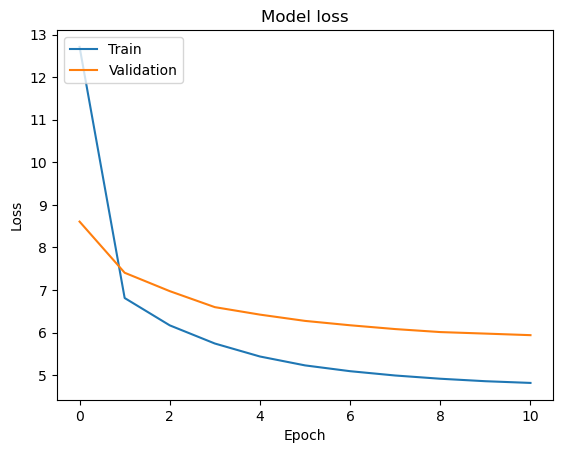

####################################################

writing to directory...
csv written in dir: /Users/mf/Desktop/CS/Studies/7_Final_Project/Kaggle_M5PointPrediction/src/submissions/sample_submission.csv


In [30]:
# Call the pipeline to run the model
forecast_df = lstm_pipeline(testing=True, write_to_disc=True)